<a href="https://colab.research.google.com/github/mrhamedani/Gen-AI-projects-Pytorch/blob/main/FashionMNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchvision.transforms as T
import torchvision
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
transforms= T.Compose([T.ToTensor(),T.Normalize([0.5],[0.5])])
train_data = torchvision.datasets.FashionMNIST(root="data",train=True,download=True,transform=transforms)
train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)

In [ ]:
D = nn.Sequential(
    nn.Linear(784,1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,1),
    nn.Sigmoid()
).to(device)

In [ ]:
G = nn.Sequential(nn.Linear(100,256),
                  nn.ReLU(),
                  nn.Linear(256,512),
                  nn.ReLU(),
                  nn.Linear(512,1024),
                  nn.ReLU(),
                  nn.Linear(1024,784),
                  nn.Tanh()).to(device)

In [ ]:
loss_fn=nn.BCELoss()
optimD= torch.optim.Adam(D.parameters(),lr=0.0002)
optimG= torch.optim.Adam(G.parameters(),lr=0.0002)

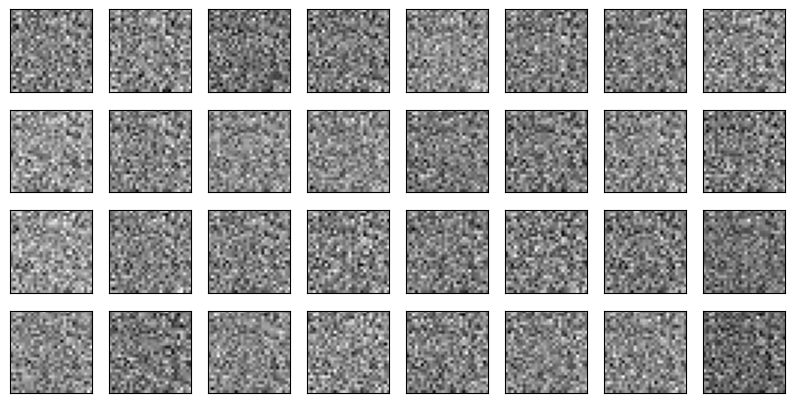

In [ ]:
def see_output():
    noise=torch.randn(32,100).to(device)
    fake_samples =G(noise).cpu().detach()
    plt.figure(figsize=(10,5))
    for i in range(32):
        ax=plt.subplot(4,8,i+1)
        img=(fake_samples[i]).reshape(28,28)
        plt.imshow(img,cmap="gray")
        plt.xticks([])
        plt.yticks([])
    plt.show()
see_output()

In [ ]:
real_labels=torch.ones(32,1).to(device)
fake_labels=torch.zeros(32,1).to(device)

In [2]:
def train_D_on_real(real_sample):
    r= real_sample.reshape(-1,784).to(device)
    out_D =D(r)
    labels= torch.ones((r.shape[0],1)).to(device) #Size dynamics
# We did not use real_labels because it is possible that the last batch of sixes will not be 32
# That's why we define it to have as many labels as its size
    loss_D = loss_fn(out_D,labels)
    loss_fn(out_D,labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D

In [ ]:
def train_D_on_fake_labels():
    noise=torch.randn(32,100).to(device)
    generated_data = G(noise)
    preds = D(generated_data)
    loss_D = loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D


In [ ]:
def train_G():
    noise=torch.randn(32,100).to(device)
    generated_data = G(noise)
    preds = D(generated_data)
    loss_G = loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return loss_G

Epoch 10 Generator loss: 2.173353910446167 Discriminator loss: 2.091778039932251


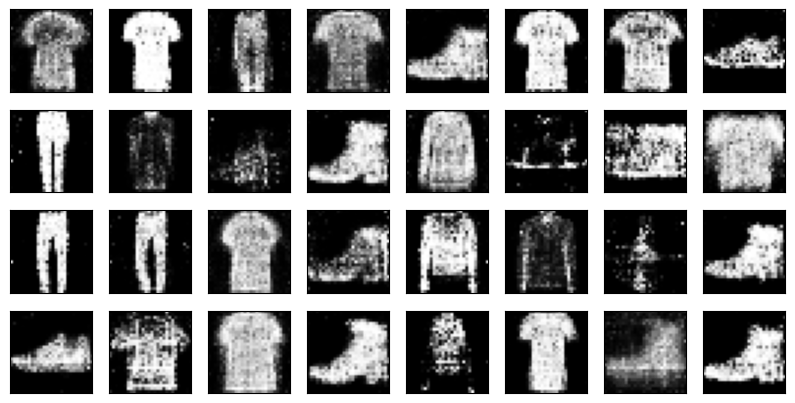

Epoch 20 Generator loss: 1.8913655281066895 Discriminator loss: 2.2579312324523926


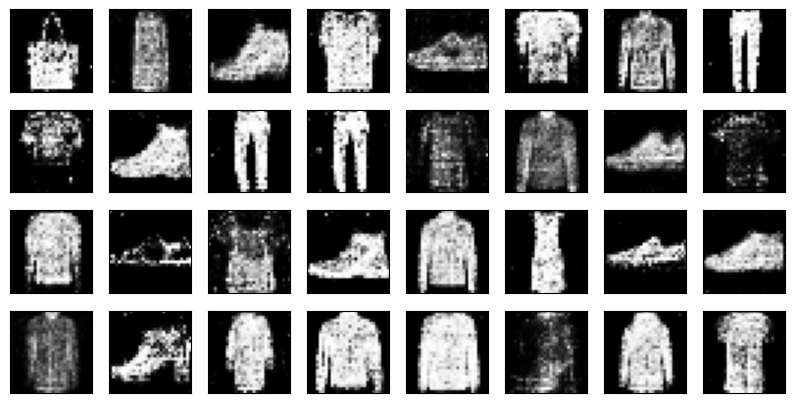

Epoch 30 Generator loss: 1.8260080814361572 Discriminator loss: 2.2969651222229004


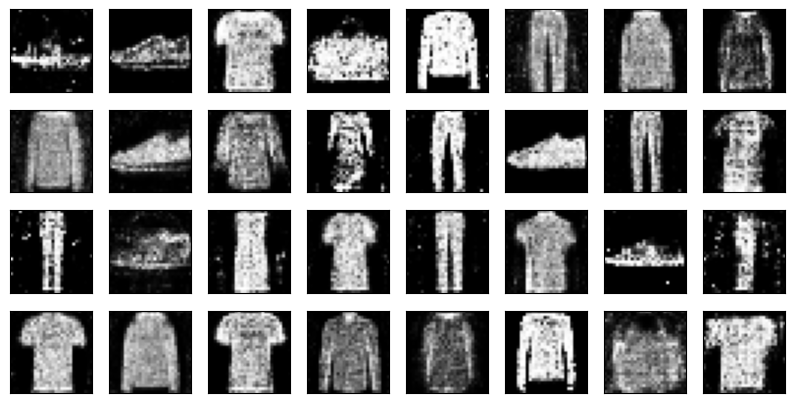

Epoch 40 Generator loss: 1.8011252880096436 Discriminator loss: 2.31268048286438


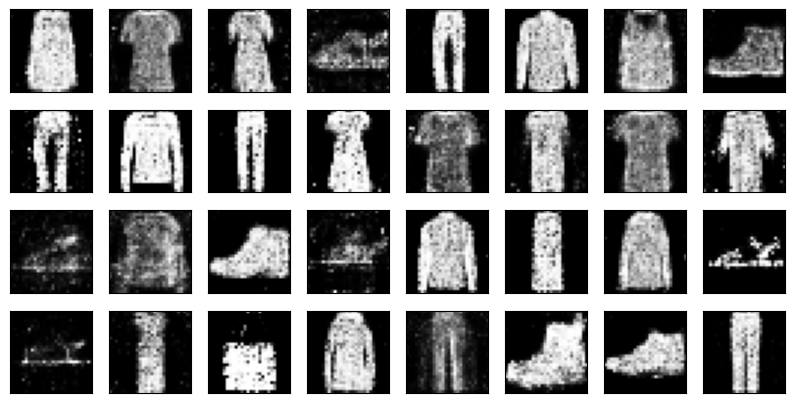

Epoch 50 Generator loss: 1.7913354635238647 Discriminator loss: 2.3179588317871094


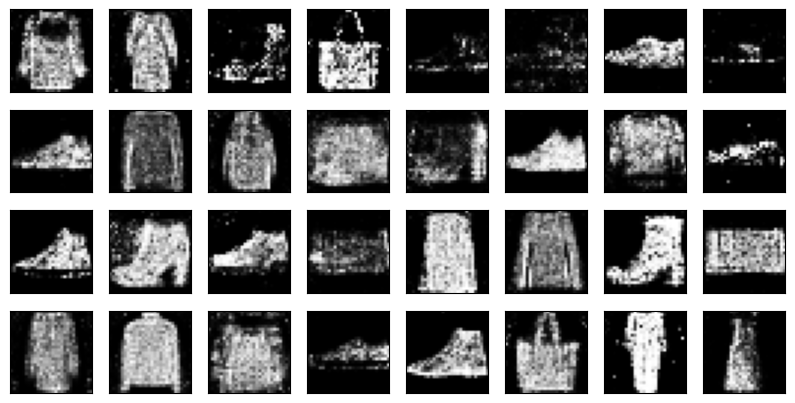

In [ ]:
for i in range(50):
    gloss=0
    dloss=0
    for n, (real_sample,_) in enumerate(train_dataloader):
#In fact, each dataloader unit that contains 32 photos in one batch.
#Each photo contains two inputs, label and real sample, the amount of the label is not important to us
        loss_D= train_D_on_real(real_sample)
        dloss+=loss_D
        loss_D= train_D_on_fake_labels()
        dloss+=loss_D
        loss_G= train_G()
        gloss+=loss_G
    gloss= gloss/n
    dloss= dloss/n
# The total loss is 32 folds (batch size) divided by this number
    if i % 10==9:
        print(f"Epoch {i+1} Generator loss: {gloss} Discriminator loss: {dloss}")
        see_output()